# Demanda de transporte

## `Auxiliar: Redes neuronales artificiales`

**Junio 2024**<br>
**Gabriel Nova** <br>
**G.N.Nova@tudelft.nl** <br>

### `Instrucciones`

**Las sesiones de laboratorio son:**<br>
* Entornos de aprendizaje donde trabajas con Jupyter y puedes resolver dudas.<br>
* No son calificadas y no tienen que ser entregadas.

### `Configuración del entorno de trabajo`

**Opción 1: Entorno local**<br>
Descomenta la siguiente celda si estás ejecutando este cuaderno en tu entorno local, para instalar todas las dependencias en tu versión de Python.


In [61]:
#!pip install -r requirements.txt

**Opción 2: Google Colab**<br>
Descomenta la siguiente celda si estás ejecutando este cuaderno en Google Colab.

In [62]:
#!git clone https://github.com/TransportDemand/CI5144
#!pip install -r CI5144/requirements_colab.txt
#!mv "/content/CI5144/Auxiliares/data" /content/data

# `Aplicación: Modelando elecciones de vecindarios` <br>
En esta sesión de laboratorio, analizaremos el comportamiento de elección de vecindarios. Comprender las preferencias de las personas sobre las características de los vecindarios es crucial para los urbanistas cuando (re)desarrollan vecindarios o diseñan políticas para abordar, por ejemplo, la segregación residencial. Durante esta sesión de laboratorio, aplicará modelos de elección discreta para descubrir las preferencias de las personas sobre atributos como la distancia al centro de la ciudad y la proporción de extranjeros en su vecindario. Además, explorará si las preferencias interactúan con covariables como la edad, el género, la propiedad de la vivienda, la propiedad del automóvil y el nivel de urbanización. Mientras lo hace, probará varias especificaciones de utilidad e interpretará los resultados de los modelos de elección discreta.

Para este estudio, utilizamos datos de un experimento de elección declarada, que se llevó a cabo entre 2017 y 2018 en cuatro ciudades europeas: Hanover, Mainz, Berna y Zurich.

**`Objetivos de aprendizaje del auxiliar`**

Después de completar el auxiliar, podrás:
* Entrenar un Perceptrón Multicapa (MLP) en datos de elección.
* Entrenar un modelo de elección híbrido, utilizando PyTorch.
* Balance entre el el comportamiento esperado y el ajuste del modelo.
* Reflexionar sobre las fortalezas y debilidades de los enfoques de modelado basados en datos y en teoría.




**`Este laboratorio consta de 4 partes`**

**Parte 1**: Preparación de datos

**Parte 2**: El modelo lineal-aditivo RUM-MNL
- Ejercicio 1: "Disposición a pagar por tiendas de comestibles"

**Parte 3**: El Perceptrón Multicapa
- Ejercicio 2: "Entrenamiento del modelo MLP"
- Ejercicio 3: "Añadiendo las características socio-demográficas"

**Parte 4**: El modelo L-MNL
- Ejercicio 4: "Característica MLP"
- Ejercicio 5: "Pronóstico utilizando el modelo L-MNL"


y comprende **`5`** ejercicios.



#### `Importar packages`

In [63]:
# Import required Python packages and modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd
from pathlib import Path

# Biogeme
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
from biogeme.expressions import Beta, Variable, log

# Scikit-learn
from sklearn.preprocessing import StandardScaler

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### **1. Preparar su base de datos**
Para preparar la base de datos, haremos lo siguiente:<br>
    1.1 Cargar la base de datos<br>
    1.2 Limpiar y preparar la base de datos<br>

 `i. Configurar el espacio de trabajo y cargar la base de datos`

In [64]:
# Obtener el ruta a la base de datos
data_path = Path(f'data/choice_data.dat')

# Cargar datos de elección de modo en un pandas DataFrame
df = pd.read_csv(data_path, sep='\t')
df.shape

(9720, 32)

**Descripción de variables**<br>

Por lo tanto, se recomienda revisar la descripción de la base de datos.

| Variable       | Descripción                                                    | Tipo/Niveles |
|----------------|---------------------------------------------------------------|--------------|
| `ID`           | ID del encuestado                                             | Entero       |
| `TASK_ID`      | Id de la tarea de elección                                    | Entero       |
| `STORES`       | Minutos caminando a los supermercados        | 2 Min., 5 Min., 10 Min., 15 Min. |
| `TRANSPORT`    | Minutos caminando al transporte público           | 2 Min., 5 Min., 10 Min., 15 Min. |
| `CITY`         | Distancia al centro de la ciudad en km                        | Menos de 1 km, 1 a 2 km, 3 a 4 km, más de 4 km |
| `NOISE`        | Ruido del tráfico en la calle                                 | 1 = Ninguno, 2 = Poco, 3 = Medio, 4 = Alto |
| `GREEN`        | Áreas verdes en la zona residencial                           | 1 = Ninguno, 2 = Pocas, 3 = Algunas, 4 = Muchas |
| `FOREIGN`      | Proporción de extranjeros en la zona residencial              | 0.10, 0.20, 0.30, 0.40 |
| `CHOICE`       | Indica la elección                                            | Entero       |
| `RESPCITY`     | Indica la ciudad. 1 = Mainz, 2 = Hanover, 3 = Berna, 4 = Zurich | Categórico   |
| `WOMAN`        | Indica 1 si es mujer y 0 de lo contrario                      | Categórico      |
| `AGE`          | Edad en años                                                  | Entero       |
| `ENVCONC`      | Preocupación ambiental de 1 a 5, siendo 5 el grado más alto de preocupación | Ordinal     |
| `EDUYEARS`     | Número de años de educación                                   | Numérico     |
| `RESPFOREIGN`  | 1 si el encuestado es extranjero, 0 de lo contrario           | Categórico      |
| `HOMEOWNER`    | Indica 1 si el encuestado es propietario de vivienda y 0 de lo contrario | Categórico      |
| `CAROWNER`     | Indica 1 si el encuestado es propietario de un auto y 0 de lo contrario | Categórico      |
| `JOB`          | 1 si el encuestado está trabajando, 0 de lo contrario         | Categórico      |
| `NONWESTERN`   | 1 si el encuestado es no occidental, 0 de lo contrario        | Categórico      |
| `WESTERN`      | 1 si el encuestado es occidental, 0 de lo contrario           | Categórico      |

**1.2 Inspeccionar, limpiar y preparar los datos**<br>
Antes de empezar a analizar los datos, asegúrate de que sabes qué conoces las características que posee.


In [65]:
df.describe()

,ID,TASK_ID,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,...,WOMAN,AGE,ENVCONC,EDUYEARS,RESPFOREIGN,HOMEOWNER,CAROWNER,JOB,NONWESTERN,WESTERN
count,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,...,9720.000000,9720.000000,9720.000000,9720.000000,9720.000000,9720.00000,9720.000000,9720.000000,9720.000000,9720.000000
mean,4936.131276,19743.025103,7.972634,7.997737,3.006996,2.495576,2.502984,0.249095,8.007407,7.937449,...,206.288477,702.665432,1937.691427,3800.628807,823.193827,41.37572,617.895885,1564.486831,41.310700,41.247737
std,2791.776351,11167.105459,4.943312,4.969792,1.581009,1.121941,1.110794,0.111187,4.937217,4.933491,...,4531.586747,8084.394737,13772.314585,19083.662381,9035.133163,2028.26417,7832.731177,12407.404755,2028.265479,2028.266745
min,2.000000,5.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.100000,2.000000,2.000000,...,0.000000,18.000000,1.000000,8.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,2541.000000,10162.750000,2.000000,2.000000,2.000000,1.000000,2.000000,0.200000,5.000000,2.000000,...,0.000000,34.000000,3.166667,13.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,5003.500000,20012.500000,5.000000,5.000000,4.000000,3.000000,3.000000,0.200000,10.000000,5.000000,...,1.000000,44.000000,3.666667,16.500000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000
75%,7305.000000,29218.250000,10.000000,15.000000,5.000000,3.000000,3.000000,0.300000,10.000000,10.000000,...,1.000000,56.000000,4.166667,18.000000,0.000000,0.00000,1.000000,1.000000,0.000000,0.000000
max,9825.000000,39300.000000,15.000000,15.000000,5.000000,4.000000,4.000000,0.400000,15.000000,15.000000,...,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.00000,99999.000000,99999.000000,99999.000000,99999.000000


La tabla de arriba proporciona información importante sobre las variables de la base de datos. El promedio y la desviación estándar (std) de algunas variables son altas. Por ejemplo, los valores medios de `WOMAN`, `AGE`, `EDUYEARS` son bastante más altos de lo esperado según la descripción de las variables. Esto podría indicar problemas en el conjunto de datos, la presencia de valores atípicos o valores perdidos. En la tabla anterior, puede verse que el número `99999` no coincide con los valores habituales de variables como `WOMEN`, `AGE` y `others`.<br>

Esto sugiere que el valor `99999` se ha utilizado para representar `valores perdidos` en el conjunto de datos.

**`Conjunto de datos para la estimación`**<br>

Dado nuestro objetivo de investigar el impacto de la edad, el sexo, la propiedad de la vivienda, la propiedad de un auto y la urbanización, tenemos que trabajar con las filas de los datos con valores que faltan en estas columnas. Afortunadamente, la proporción de datos que faltan en estas columnas es relativamente pequeña. Por lo tanto, una estrategia razonable en este caso es simplemente eliminar las filas de datos con valores que faltan en estas columnas. Otra estrategia podría haber sido imputar los valores de la media. Sin embargo, esta estrategia también tiene sus desventajas.

In [66]:
#lista de características relevantes
id         = ['ID', 'TASK_ID' ]
attributes =   ['STORES1', 'TRANSPORT1', 'CITY1', 'NOISE1', 'GREEN1', 'FOREIGN1', 
                'STORES2', 'TRANSPORT2', 'CITY2', 'NOISE2', 'GREEN2', 'FOREIGN2',
                'STORES3', 'TRANSPORT3', 'CITY3', 'NOISE3', 'GREEN3', 'FOREIGN3']

sociovars = ['AGE','WOMAN','HOMEOWNER','CAROWNER','RESPCITY', 'JOB', 'EDUYEARS', 'ENVCONC']

# Crear una nueva instancia del dataframe, con los atributos, las variables socio-demográficas y la elección.
dff = df[ id + attributes + sociovars + ['CHOICE']].copy()

# Reemplazar 9999 por NaN
dff = dff.replace(99999, np.nan)

# Eliminar las filas con datos que faltan en las características relevantes
dff = dff.dropna(subset=sociovars, how='any')

dff.describe()

,ID,TASK_ID,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,...,FOREIGN3,AGE,WOMAN,HOMEOWNER,CAROWNER,RESPCITY,JOB,EDUYEARS,ENVCONC,CHOICE
count,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,...,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000
mean,4938.589460,19752.857839,7.981842,7.978299,3.007418,2.496678,2.503432,0.249302,8.002214,7.948406,...,0.250498,44.530115,0.532329,0.224092,0.624004,2.614703,0.735607,15.254650,3.625000,1.958924
std,2798.272394,11193.089632,4.945691,4.966099,1.581524,1.121651,1.112332,0.111112,4.939272,4.931868,...,0.112500,13.463328,0.498981,0.417006,0.484406,1.108207,0.441034,2.702097,0.771467,0.813718
min,2.000000,5.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.100000,2.000000,2.000000,...,0.100000,18.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.000000,1.000000,1.000000
25%,2535.000000,10138.750000,5.000000,2.000000,2.000000,1.000000,2.000000,0.200000,5.000000,2.000000,...,0.100000,33.000000,0.000000,0.000000,0.000000,2.000000,0.000000,13.000000,3.166667,1.000000
50%,5032.500000,20128.500000,5.000000,5.000000,4.000000,3.000000,3.000000,0.200000,10.000000,5.000000,...,0.300000,44.000000,1.000000,0.000000,1.000000,3.000000,1.000000,16.000000,3.666667,2.000000
75%,7335.000000,29338.250000,10.000000,15.000000,5.000000,4.000000,3.000000,0.300000,10.000000,10.000000,...,0.400000,56.000000,1.000000,0.000000,1.000000,4.000000,1.000000,18.000000,4.166667,3.000000
max,9813.000000,39252.000000,15.000000,15.000000,5.000000,4.000000,4.000000,0.400000,15.000000,15.000000,...,0.400000,70.000000,1.000000,1.000000,1.000000,4.000000,1.000000,18.000000,5.000000,3.000000


Recodificar las variables sociodemográficas categóricas

In [67]:
# Crear un dataframe con las variables socio demográficas relevantes
df_sociovars  = dff[sociovars].astype(int)

# Recodificar 'AGE' 
df_sociovars.loc[(      df_sociovars['AGE'] < 25), 'AGE'] = 1
df_sociovars.loc[(25 <= df_sociovars['AGE']     ) &
                 (      df_sociovars['AGE'] < 60), 'AGE'] = 2
df_sociovars.loc[(60 <= df_sociovars['AGE']     ), 'AGE'] = 3

# Recodificar 'EDUYEARS'
df_sociovars.loc[(      df_sociovars['EDUYEARS'] < 10), 'EDUYEARS'] = 1
df_sociovars.loc[(10 <= df_sociovars['EDUYEARS']     ) & 
                 (      df_sociovars['EDUYEARS'] < 14), 'EDUYEARS'] = 2
df_sociovars.loc[(14 <= df_sociovars['EDUYEARS']     ), 'EDUYEARS'] = 3

# Recodificar
df_sociovars.loc[(     df_sociovars['ENVCONC'] < 3), 'ENVCONC'] = 1
df_sociovars.loc[(3 <= df_sociovars['ENVCONC']    ) & 
                 (     df_sociovars['ENVCONC'] < 4), 'ENVCONC'] = 2
df_sociovars.loc[(4 <= df_sociovars['ENVCONC']    ), 'ENVCONC'] = 3

#Convertir variables categóricas en variables dummies utilizando pd.get_dummies()
df_sociovars = pd.get_dummies(data = df_sociovars, prefix = sociovars, prefix_sep='_', columns = sociovars, drop_first = True, dtype=int)

# Crear una variable con los nombres de las variables sociodemográficas
features_socio = df_sociovars.columns.tolist()

Por último, cree el dataframe para el entrenamiento, que contiene el «ID», la «CHOICE», los atributos y las variables sociodemográficas codificados como dummies.

In [68]:
#Concatenar las variables socio demográficas con las características relevantes de las alternativas
dff = pd.concat([dff[['ID', 'CHOICE'] + attributes], df_sociovars], axis=1)

print(dff.shape)
dff.describe()

(9032, 33)


,ID,CHOICE,STORES1,TRANSPORT1,CITY1,NOISE1,GREEN1,FOREIGN1,STORES2,TRANSPORT2,...,HOMEOWNER_1,CAROWNER_1,RESPCITY_2,RESPCITY_3,RESPCITY_4,JOB_1,EDUYEARS_2,EDUYEARS_3,ENVCONC_2,ENVCONC_3
count,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,...,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.000000,9032.00000,9032.000000
mean,4938.589460,1.958924,7.981842,7.978299,3.007418,2.496678,2.503432,0.249302,8.002214,7.948406,...,0.224092,0.624004,0.176705,0.327724,0.260850,0.735607,0.323295,0.643047,0.44597,0.370682
std,2798.272394,0.813718,4.945691,4.966099,1.581524,1.121651,1.112332,0.111112,4.939272,4.931868,...,0.417006,0.484406,0.381440,0.469409,0.439123,0.441034,0.467760,0.479127,0.49710,0.483014
min,2.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.100000,2.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,2535.000000,1.000000,5.000000,2.000000,2.000000,1.000000,2.000000,0.200000,5.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,5032.500000,2.000000,5.000000,5.000000,4.000000,3.000000,3.000000,0.200000,10.000000,5.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000
75%,7335.000000,3.000000,10.000000,15.000000,5.000000,4.000000,3.000000,0.300000,10.000000,10.000000,...,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000
max,9813.000000,3.000000,15.000000,15.000000,5.000000,4.000000,4.000000,0.400000,15.000000,15.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


`ii. Dividir los datos en un conjunto de entrenamiento y otro de test`

In [69]:
# Fijar una semilla para la reproducibilidad
np.random.seed(100)
dff['draw']=float('nan')
for i in dff['ID'].unique():
    num_obs = len(dff.loc[dff['ID']==i,'draw'])
    dff.loc[dff['ID']==i,'draw']= np.repeat(np.random.uniform(0,1,1),num_obs)

# Poner el 80% de los datos en el conjunto de entrenamiento y el 20% en el conjunto de prueba
df_train = dff.loc[dff['draw']< 0.8,:].copy()
df_test  = dff.loc[dff['draw']>=0.8,:].copy()

# Número de observaciones en los conjuntos de entrenamiento y prueba
num_obs_train = len(df_train)
num_obs_test  = len(df_test)

print(f'Número de individuos en df_train y df_test: \t{df_train.ID.nunique()}  {df_test.ID.nunique()} ')
print(f'Número de observaciones en df_train y df_test: \t{len(df_train)} {len(df_test)} ')

Número de individuos en df_train y df_test: 	1832  426 
Número de observaciones en df_train y df_test: 	7328 1704 


`iii. Escalar las características`<br>
Para entrenar RNA de forma eficiente, se recomienda escalar (es decir, normalizar) las características. Existen varias formas de escalar los datos. A menudo se utiliza un escalador de sk-learn llamado 'StandardScaler'. Este escalador normaliza la varianza y desplaza la ubicación de la distribución a cero, vea https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [70]:
# Crear X_train y X_test
x_train = df_train[attributes + features_socio]
x_test  = df_test [attributes + features_socio]

# Inicializar el objeto scaler
scaler = StandardScaler()

# Ajustar y transformar los datos de entrenamiento
scaler = scaler.fit(dff[attributes + features_socio])

# Aplicar el escalador ajustado a los conjuntos de datos
x_train_scaled = pd.DataFrame(scaler.transform(df_train[attributes + features_socio]), columns=[attributes + features_socio])
x_test_scaled =  pd.DataFrame(scaler.transform(df_test [attributes + features_socio]), columns=[attributes + features_socio]) 

print('Dimensión de x_train', x_train_scaled.shape)
print('Dimensión de x_test', x_test_scaled.shape)

# Crear valores de etiquetas 
# Y debe ser una matriz codificada como dummies
y_train_dummy = pd.get_dummies(df_train['CHOICE']).values.astype(int)
y_test_dummy = pd.get_dummies(df_test['CHOICE']).values.astype(int)

Dimensión de x_train (7328, 31)
Dimensión de x_test (1704, 31)


`iv. Convertir a tensores`<br>
Muchos paquetes de machine learning trabajan con los llamados tensores. Los tensores son estructuras de datos dedicadas a entrenar eficientemente redes neuronales. Por tanto, necesitamos convertir las características y el etiqueta en un tipo de datos tensores. En PyTorch, esto se hace con `torch.tensor()`.
 

In [71]:
# Crear tensores para el conjunto de entrenamiento
# En este caso, usamos sólo las características de las alternativas 'features_alt'
x_train_tensor = torch.tensor(x_train_scaled[attributes].values, dtype=torch.float)
y_train_dummy_tensor = torch.tensor(y_train_dummy, dtype=torch.float)

# Crear tensores para el conjunto de test
x_test_tensor = torch.tensor(x_test_scaled[attributes].values, dtype=torch.float)
y_test_dummy_tensor = torch.tensor(y_test_dummy, dtype=torch.float)

print('Dimensión de x_train_tensor\t', x_train_tensor.shape)
print('Dimensión de x_test_tensor\t', x_test_tensor.shape)

Dimensión de x_train_tensor	 torch.Size([7328, 18])
Dimensión de x_test_tensor	 torch.Size([1704, 18])


## `2. Estimación de un modelo de benchmark RUM-MNL lineal aditivo` 

`i. Estimación del modelo`<br>
Primero estimamos nuestro modelo de benchmark RUM-MNL lineal-aditivo.

In [72]:
biodata_train = db.Database('neighbourhood_data_train', df_train)

STORES1     = Variable('STORES1')
TRANSPORT1  = Variable('TRANSPORT1')
CITY1       = Variable('CITY1')
NOISE1      = Variable('NOISE1')
GREEN1      = Variable('GREEN1')
FOREIGN1    = Variable('FOREIGN1')

STORES2     = Variable('STORES2')
TRANSPORT2  = Variable('TRANSPORT2')
CITY2       = Variable('CITY2')
NOISE2      = Variable('NOISE2')
GREEN2      = Variable('GREEN2')
FOREIGN2    = Variable('FOREIGN2')
    
STORES3     = Variable('STORES3')
TRANSPORT3  = Variable('TRANSPORT3')
CITY3       = Variable('CITY3')
NOISE3      = Variable('NOISE3')
GREEN3      = Variable('GREEN3')
FOREIGN3    = Variable('FOREIGN3')

CHOICE      = Variable('CHOICE')

In [73]:
model_name = 'Linear-additive RUM-MNL'

B_stores    = Beta('B_stores'   , 0, None, None, 0)
B_transport = Beta('B_transport', 0, None, None, 0)
B_city      = Beta('B_city'     , 0, None, None, 0)
B_noise     = Beta('B_noise'    , 0, None, None, 0)
B_green     = Beta('B_green'    , 0, None, None, 0)
B_foreign   = Beta('B_foreign'  , 0, None, None, 0)

V1 = B_stores * STORES1 + B_transport * TRANSPORT1 + B_city * CITY1 + B_noise * NOISE1 + B_green * GREEN1 + B_foreign * FOREIGN1
V2 = B_stores * STORES2 + B_transport * TRANSPORT2 + B_city * CITY2 + B_noise * NOISE2 + B_green * GREEN2 + B_foreign * FOREIGN2
V3 = B_stores * STORES3 + B_transport * TRANSPORT3 + B_city * CITY3 + B_noise * NOISE3 + B_green * GREEN3 + B_foreign * FOREIGN3

V  = {1: V1, 2: V2, 3: V3}    
AV = {1: 1, 2: 1, 3: 1} 

prob = models.logit(V, AV, CHOICE)

biogeme = bio.BIOGEME(biodata_train, log(prob))

biogeme.generate_pickle = False
biogeme.generate_html = False
biogeme.saveIterations = False
biogeme.modelName = model_name

biogeme.calculateNullLoglikelihood(AV)
results = biogeme.estimate()
print(results.short_summary())

beta_hat = results.getEstimatedParameters()
beta_hat

Results for model Linear-additive RUM-MNL
Nbr of parameters:		6
Sample size:			7328
Excluded data:			0
Null log likelihood:		-8050.631
Final log likelihood:		-6471.391
Likelihood ratio test (null):		3158.48
Rho square (null):			0.196
Rho bar square (null):			0.195
Akaike Information Criterion:	12954.78
Bayesian Information Criterion:	12996.18



,Value,Rob. Std err,Rob. t-test,Rob. p-value
B_city,-0.170377,0.009225,-18.468215,0.0
B_foreign,-1.193204,0.125067,-9.540546,0.0
B_green,0.416362,0.013073,31.849350,0.0
B_noise,-0.448441,0.012045,-37.230843,0.0
B_stores,-0.036265,0.002974,-12.193653,0.0
B_transport,-0.076922,0.002839,-27.095476,0.0


`ii. Calcular la LL del modelo estimado en el conjunto de pruebas`.

In [74]:
# Crear el objeto Biogeme para la base de datos de prueba
biodate_test = db.Database('Neighbourhood_data_test', df_test)

# Simular la probabilidad de eleccion considerando el modelo MNL en los datos de prueba
dict2simulate = {'prob_chosen':prob}

# Crear el objeto de simulacion y calcular las probabilidades
biosim = bio.BIOGEME(biodate_test,dict2simulate)
simulated_probs = biosim.simulate(theBetaValues=results.getBetaValues())

# Calcular Calculate la LL del MNL en la base de datos de prueba
LL_MNL_test = np.log(simulated_probs['prob_chosen']).sum()
print(f'LL MNL test: {LL_MNL_test:0.2f}')

LL MNL test: -1543.88


### ``Ejercicio 1: Disposición a pagar por vivir mas cerca de los supermercados``

`A` Calcule la disposición a pagar para reducir el número de minutos caminando hasta las tiendas de comestibles en un minuto, expresado en términos de minutos caminando hasta el transporte público. Usa la fórmula::<br><br>
$WTP = \frac{\beta_{stores}}{\beta_{transport}}$<br><br>
`B` Interprete este resultado. ¿Qué encuentran más importante las personas; minutos caminando hasta los supermercados o minutos caminando hasta el transporte público?

$\color{green}{\text{Añade tus respuestas aqui}}$

In [75]:
# Añade tu código aquí

In [76]:
# ANSWERS
# A
WTP_MNL = beta_hat.loc['B_stores']['Value']/beta_hat.loc['B_transport']['Value']
print(f'\nLa disposición a pagar para reducir un minuto el tiempo que se tarda en ir caminando al supermercado es: {WTP_MNL:.2f} minutos caminando hasta el transporte público')

# B
print('\nLa distancia al transporte público es casi dos veces más importante que la distancia a los supermercados porque el WTP es < 1')


La disposición a pagar para reducir un minuto el tiempo que se tarda en ir caminando al supermercado es: 0.47 minutos caminando hasta el transporte público

La distancia al transporte público es casi dos veces más importante que la distancia a los supermercados porque el WTP es < 1


## `3. El modelo MLP`

A El perceptrón multicapa (MLP) es una red neuronal ampliamente utilizada en el machine learning por su capacidad para aprender patrones complejos. Está compuesto por capas ocultas con neuronas y funciones de activación. <br>

Por ejemplo, en la siguiente imagen, podemos ver una capa de entrada con 8 características, dos capas ocultas con 10 nodos ocultos cada una, y la capa de salida con 3 clases de salida:<br>

<p align="center\">
<img width="800" src="Assets/MLP.png">
</p> 

`i. Definición del modelo MLP`<br>

Crearemos una red neuronal totalmente conectada con dos capas ocultas. Para ello, crearemos una nueva clase utilizando el módulo nn.Module de PyTorch. 

En este caso, tendremos una capa de entrada de tamaño `input_size`, dos capas ocultas de tamaños `hidden_size1` y `hidden_size2` respectivamente, y una capa de salida de tamaño `output_size`. 

Además, definiremos la función de propragación. La función de propragación toma un valor de entrada `x`, lo pasa a través de las capas de la red, al tiempo que aplica funciones de activación. 

El resultado son las utilidades de cada alternativa `V`.

In [77]:
# Red neuronal totalmente conectada con dos capas ocultas

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        x = torch.tanh(self.fc1(x)) # función de activación tanh para la 1 capa
        x = torch.tanh(self.fc2(x)) # función de activación tanh para la 2 capa
        V = self.fc3(x)             # función de activación lineal para la capa de salida

        return V                    # devuelve la «Utilidad» de cada alternativa

`ii. Creación de DataLoaders`<br>
A través de un objeto PyTorch Dataloader se maneja eficientemente el flujo de datos durante el entrenamiento y las evaluaciones. Este crea mini lotes, y se asegura de que las instancias de los datos se utilicen en cada época. <br>

Crearemos un DataLoader para los conjuntos de datos de entrenamiento y prueba. 

In [78]:
# Crear un DataLoader para el conjunto de entrenamientos
dataset_train = TensorDataset(x_train_tensor, y_train_dummy_tensor)
train_loader = DataLoader(dataset_train, batch_size=250, shuffle=True)

# Crear un DataLoader para el conjunto de pruebas
dataset_test = TensorDataset(x_test_tensor, y_test_dummy_tensor)
test_loader = DataLoader(dataset_test, batch_size=len(x_test_tensor), shuffle=True)

`iii. Definir funciones`<br>
Definiremos las siguientes funciones:
1. Una función para evaluar el rendimiento del modelo durante el entrenamiento.
2. Una función para visualizar el progreso del entrenamiento.
3. Una función para examinar el modelo.

In [79]:
def evaluate(model, criterion, data_loader):
    model.eval()  # Poner el modelo en modo evaluación
    total_loss = 0.0

    with torch.no_grad():
        for inputs, labels in data_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss

Esta función visualiza el progreso del entrenamiento. Llamamos a esta función una vez finalizado el entrenamiento.

In [80]:
def show_loss_plot(train_losses, test_losses, num_obs_train, num_obs_test):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(np.array(train_losses)/num_obs_train, label='Training Loss')
    ax.plot(np.array(test_losses)/num_obs_test,   label='Test Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    plt.show()

Esta función nos permite inspeccionar la arquitectura del modelo creado. Enumera el número de pesos por capa y sus tamaños de entrada y salida. 

In [81]:
def print_model_summary(model):
    total_params = 0
    print(f"=== Model Summary ===")
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_params = param.numel()
            total_params += num_params
            print(f"Layer: {name:20}|\t Weights: {num_params}")

    print(f"\nTotal trainable Weights: {total_params}")

    print("\n=== Layers ===")
    for layer in model.children():
        print(layer)

`iv. Crear el objeto MLP`<br>

In [82]:
# Definir las dimensiones del MLP
input_size   = x_train_tensor.size()[1]  # Número de características de entrada
hidden_size1 = 10                        # Número de nodos en la primera capa oculta
hidden_size2 = 10                        # Número de nodos en la primera capa oculta
output_size  = 3                         # Número de clases (determinado por el numero de alternativas)
print(f' input_size = {input_size}, hidden_size1 = {hidden_size1}, hidden_size2 = {hidden_size2}, output_size = {output_size}')

 input_size = 18, hidden_size1 = 10, hidden_size2 = 10, output_size = 3


In [83]:
# Invocar el modelo MLP
model = MLP(input_size, hidden_size1, hidden_size2, output_size)

# Mostrar la arquitectura del modelo
print_model_summary(model)

=== Model Summary ===
Layer: fc1.weight          |	 Weights: 180
Layer: fc1.bias            |	 Weights: 10
Layer: fc2.weight          |	 Weights: 100
Layer: fc2.bias            |	 Weights: 10
Layer: fc3.weight          |	 Weights: 30
Layer: fc3.bias            |	 Weights: 3

Total trainable Weights: 333

=== Layers ===
Linear(in_features=18, out_features=10, bias=True)
Linear(in_features=10, out_features=10, bias=True)
Linear(in_features=10, out_features=3, bias=True)


`v. Entrenar el modelo MLP`<br>
Finalmente, ¡estamos listos para entrenar el modelo!

In [84]:
nEpoch = 500 # Establecer el número de epochs
lr = 0.0001 # Establecer la tasa de aprendizaje
status = 10 # Imprimir estado cada 'status' épocas
patience = 5 # Número de epochs a esperar antes de parar preventivamente

Epoch [    1/500], Train Loss: 8276.667, Test Loss: 1907.639
Epoch [   10/500], Train Loss: 7851.364, Test Loss: 1813.829
Epoch [   20/500], Train Loss: 7428.162, Test Loss: 1722.638
Epoch [   30/500], Train Loss: 7055.410, Test Loss: 1646.358
Epoch [   40/500], Train Loss: 6739.162, Test Loss: 1585.970
Epoch [   50/500], Train Loss: 6489.418, Test Loss: 1541.564
Epoch [   60/500], Train Loss: 6319.984, Test Loss: 1513.048
Epoch [   70/500], Train Loss: 6217.813, Test Loss: 1496.014
Epoch [   80/500], Train Loss: 6158.208, Test Loss: 1485.112
Epoch [   90/500], Train Loss: 6121.048, Test Loss: 1477.421
Epoch [  100/500], Train Loss: 6096.684, Test Loss: 1471.862
Epoch [  110/500], Train Loss: 6079.722, Test Loss: 1467.640
Epoch [  120/500], Train Loss: 6067.304, Test Loss: 1464.320
Epoch [  130/500], Train Loss: 6058.189, Test Loss: 1461.983
Epoch [  140/500], Train Loss: 6051.103, Test Loss: 1459.989
Epoch [  150/500], Train Loss: 6045.186, Test Loss: 1458.389
Epoch [  160/500], Train

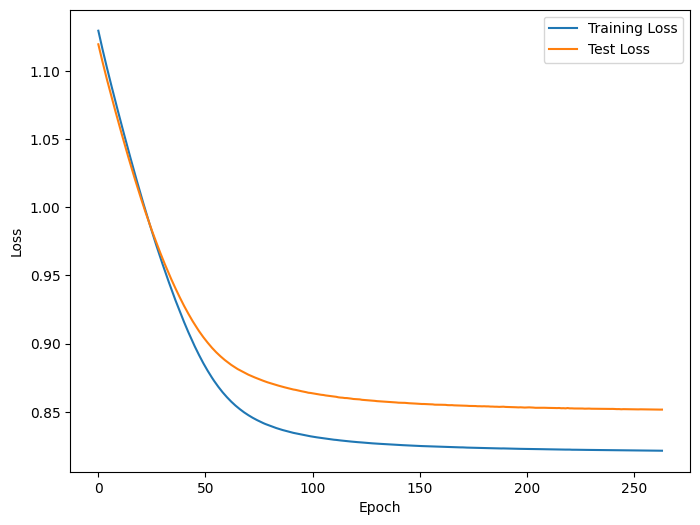

In [85]:
do_training = True
if do_training == True:

    # Definir el modelo, la función de pérdida y el optimizador
    
    optimizer = optim.Adam(params=model.parameters(), lr=lr,  betas=(0.9, 0.999), eps=1e-07, weight_decay=0)
    loss_fn = nn.CrossEntropyLoss(reduction='sum')

    # Definir listas para almacenar los valores de loss 
    train_losses = []
    test_losses = []

    # Inicializar el contador de parada anticipada 
    counter = 0
    best_loss = np.inf  # Establece la pérdida inicial a infinito

    # Bucle de entrenamiento
    for epoch in range(nEpoch):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Poner a cero los gradientes
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)   

            # Calcular la perdida
            loss = loss_fn(outputs, labels)

            # Backward pass y optimizacion
            loss.backward()
            optimizer.step()

            # Actualizar la pérdida
            running_loss += loss.item() # Log-verosimilitud en el conjunto de entrenamiento

        # Evaluar en el conjunto de prueba
        test_loss = evaluate(model, loss_fn, test_loader) # Log-verosimilitud en el conjunto de prueba

        
        if epoch == 0 or (epoch + 1) % status == 0:
            print(f'Epoch [{epoch+1:5.0f}/{nEpoch}], Train Loss: {running_loss:0.3f}, Test Loss: {test_loss:0.3f}')

        # Almacenar pérdidas
        train_losses.append(running_loss)
        test_losses.append(test_loss)

        # Implementar la parada anticipada
        if test_loss < best_loss:
            best_loss = test_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Parada anticipada en la epch {epoch+1}')
                break
            
    print(f'\nEntrenamiento finalizado. \tPérdida de entrenamiento: {running_loss:0.3f}, Pérdida de test: {test_loss:0.3f}')
    show_loss_plot(train_losses, test_losses,num_obs_train, num_obs_test)

### `Ejercicio 2: Entrenamiento del modelo MLP`

`A` Compare el rendimiento en el conjunto de prueba del MLP con el MNL de referencia. ¿Ha mejorado (mucho)? ¿Qué nos dice esto? <br>
`B` Reentrena el MLP utilizando las siguientes arquitecturas: {hidden_size1,hidden_size2} = {1,1}, {3,3}, {1,20}, {20,1}, {20,3}, {20,20}<br>
`C` ¿El aumento del número de neuronas conduce a un mejor rendimiento de generalización (es decir, mayor LL_test)? ¿Qué ocurre?
`D` Explique por qué {1,1} y {20,1} y {1,20} conducen a un rendimiento pobre. <br>
`E` Reentrene su modelo con una tasa de aprendizaje menor y mayor: lr = 0,01 y lr = 0,00001. Use {hidden_size1,hidden_size2} = {5,5}. Explique lo que ocurre.

$\color{green}{\text{Añada aquí sus respuestas}}$

In [86]:
#Añada su código aquí

In [87]:
# RESPUESTAS
#`A` El MLP mejora el ajuste del modelo en casi 100 puntos LL. Esto es mucho. Indica que el supuesto de utilidad lineal aditiva es demasiado restrictivo.

#`B`
#{1,1} da un pobre rendimiento de generalización: LL = ~-1590
#{3,3} da un rendimiento de generalización aceptable: LL = ~-1400
#{1,20} da un rendimiento de generalización deficiente: LL = ~-1500
#{20,1} da un rendimiento de generalización deficiente: LL = ~-1500
#{20,3} da un rendimiento de generalización aceptable: LL = ~-1400 

#`C` El aumento de {1,1} a {3,3} aumentar el desempeño en LL_test. Pero {20,20} no ayuda a que aumente más. 

#`D` Toda la información es comprimida en un nodo. Por lo tanto, los modelos no son capaces de asociar características a alternativas, lo que lleva a un rendimiento pobre.

#`E` Un lr grande lleva a un entrenamiento rápido. Pero inestabilidad cerca de la convergencia. Un lr pequeño conduce a un entrenamiento lento. El modelo no estaba cerca de la convergencia cuando se alcanzó el número máximo de épocas de entrenamiento. 

### `Ejercicio 3: Añadir las características sociodemográficas`

En la sección 1, en `iv. Convertir en tensores` decidimos utilizar sólo las características de las alternativas como entradas (es decir, `features_alt`), mientras que en la sesión de laboratorio 1 vimos que al menos el género (`WOMAN`) y la ciudad de residencia (`RESPCITY`) tienen cierto poder explicativo.<br>

`A` Modifica el código en esta celda para que también se utilicen estas características socio demográficas. Después, vuelva a entrenar el MLP.
`B` Quizás en contra de sus expectativas, el rendimiento del modelo no aumenta mucho. 
¿Qué nos dice esto sobre: 
1. el poder explicativo de las características sociodemográficas para la elección de la zona residencial, y 
2. la capacidad de los modelos MLP para aprender efectos de interacción sutiles? 

$\color{green}{\text{Añada aquí sus respuestas}}$

In [88]:
#Añada su código aquí

In [89]:
# ANSWERS
do_exercise3 = False
if do_exercise3 == True:
    #### Recrear tensores para los datos de entrenamiento ####
    features_alt = attributes
    #En este caso, utilizamos las características de las alternativas 'features_alt', WOMAN y RESPCITY.
    selected_features = features_alt + ['WOMAN_1', 'RESPCITY_2', 'RESPCITY_3', 'RESPCITY_4']

    x_train_tensor = torch.tensor(x_train_scaled[selected_features].values, dtype=torch.float)
    y_train_dummy_tensor = torch.tensor(y_train_dummy, dtype=torch.float)

    x_test_tensor = torch.tensor(x_test_scaled[selected_features].values, dtype=torch.float)
    y_test_dummy_tensor = torch.tensor(y_test_dummy, dtype=torch.float)



    #### Recrear DataLoader ####
    dataset_train = TensorDataset(x_train_tensor, y_train_dummy_tensor)
    train_loader = DataLoader(dataset_train, batch_size=250, shuffle=True)

    dataset_test = TensorDataset(x_test_tensor, y_test_dummy_tensor)
    test_loader = DataLoader(dataset_test, batch_size=len(x_test_tensor), shuffle=True)



    #### Redefinir la dimension de MLP  ####
    input_size   = x_train_tensor.size()[1]  
    hidden_size1 = 20                        
    hidden_size2 = 20                        
    output_size  = 3                         

## `4. El modelo L-MNL `

A continuación, construiremos y entrenaremos un modelo híbrido, concretamente el modelo L-MNL. Este modelo combina una parte interpretable siguiendo los supuestos del modelo MNL y una red neuronal que procesa el resto de variables que no queremos interpretar. Más concretamente, queremos la **flexibilidad** del MLP pero aún así queremos obtener una **estimación de la disposición a pagar por reducir el tiempo de caminata a los supermercados, expresada en términos del tiempo al transporte público**.

La figura siguiente muestra conceptualmente este modelo:<br>

<p align="center">
<img width="600" src="assets/hybrid_model.png">
</p>

`i. Definir el modelo L-MNL`<br>
Para crear el modelo L-MNL,creamos una nueva clase utilizando nn.Module de PyTorch. <br>
* La parte MNL se implementa con capas lineales separadas para las características («transport» y «foreign»), permitiendo calcular la utilidad para cada alternativa. <br>
* La parte MLP consiste en dos capas ocultas (linear1 y linear2) con un número dado de neuronas.<br>
* La función forward toma `x_mnl` y `x_mlp` como entradas. x_mlp se pasa a través de las capas de la red (`V_MLP`), mientras que x_mnl se utiliza para calcular las utilidades de forma lineal aditiva (`V_MNL`). 
* Finalmente, se suman las utilidades de ambas partes.

In [90]:
class LMNL(nn.Module):
    def __init__(self, input_size_mlp, hidden_size1, hidden_size2,output_size):
        super(LMNL,self).__init__()

        # Crear betas para la parte MNL
        self.B_transport = nn.Linear(1, 1, bias=False )
        self.B_stores   = nn.Linear(1, 1, bias=False )
                                 
        # Crear las capas ocultas para la parte MLP 
        self.linear1 = nn.Linear(input_size_mlp, hidden_size1, bias=False)
        self.linear2 = nn.Linear(hidden_size1,   hidden_size2, bias=False) 
        self.linear3 = nn.Linear(hidden_size2,   output_size,  bias=False) 

    def forward(self, X_MNL, X_MLP):
        
        # Funcion de utilidad para la parte MNL 
        V_A = self.B_transport(X_MNL[:,0].unsqueeze(1))  + self.B_stores(X_MNL[:,1].unsqueeze(1))
        V_B = self.B_transport(X_MNL[:,2].unsqueeze(1))  + self.B_stores(X_MNL[:,3].unsqueeze(1))
        V_C = self.B_transport(X_MNL[:,4].unsqueeze(1))  + self.B_stores(X_MNL[:,5].unsqueeze(1))
                     
        # Concatenating tensors to maintain the output dimension
        V_MNL = torch.cat((V_A, V_B, V_C), dim=1)

        # La parte MLP
        X_MLP = torch.tanh(self.linear1(X_MLP)) 
        X_MLP = torch.tanh(self.linear2(X_MLP)) 
        V_MLP = self.linear3(X_MLP)             

        V = V_MNL + V_MLP
        return V

`ii. Preparar los datos para entrenar el modelo L-MNL`<br>

Necesitamos dividir las características que van en las partes MLP y MNL. Porque queremos calcular la WTP de los supermercados sobre el transporte. Por lo tanto, las características relacionadas con el transporte y las tiendas van a la parte MNL, mientras que las demás características, incluidas las sociodemográficas, van a la parte MLP.

 **Importante**, las características MNL NO deben escalarse.

In [91]:
features_mnl = ['TRANSPORT1', 'STORES1','TRANSPORT2', 'STORES2','TRANSPORT3', 'STORES3']
x_mnl_train = x_train[features_mnl]
x_mnl_test  = x_test[features_mnl]

print('Dimesión de x_mnl_train\t', x_mnl_train.shape)
print('Dimesión de x_mnl_test\t', x_mnl_test.shape)

features_mlp_alt = ['FOREIGN1', 'CITY1', 'NOISE1', 'GREEN1', 
                    'FOREIGN2', 'CITY2', 'NOISE2', 'GREEN2', 
                    'FOREIGN3', 'CITY3', 'NOISE3', 'GREEN3']


features_socio = ['RESPCITY_2','RESPCITY_3','RESPCITY_4']
x_mlp_train = x_train_scaled[features_mlp_alt + features_socio]
x_mlp_test  = x_test_scaled[features_mlp_alt + features_socio]

print('\nDimesión de x_mlp_train\t', x_mlp_train.shape)
print('Dimesión de x_mlp_test\t', x_mlp_test.shape)

Dimesión de x_mnl_train	 (7328, 6)
Dimesión de x_mnl_test	 (1704, 6)

Dimesión de x_mlp_train	 (7328, 15)
Dimesión de x_mlp_test	 (1704, 15)


Convertir datos en tensores PyTorch

In [92]:
# Entrenamiento
x_mnl_train_tensor = torch.tensor(x_mnl_train.values, dtype=torch.float)
x_mlp_train_tensor = torch.tensor(x_mlp_train.values, dtype=torch.float)
y_train_dummy_tensor = torch.tensor(y_train_dummy,    dtype=torch.float)

# test
x_mnl_test_tensor = torch.tensor(x_mnl_test.values, dtype=torch.float)
x_mlp_test_tensor = torch.tensor(x_mlp_test.values, dtype=torch.float)
y_test_dummy_tensor = torch.tensor(y_test_dummy,    dtype=torch.float)

print('Tamaño del tensor X_mnl_train = ', x_mnl_train_tensor.size())
print('Tamaño del tensor X_mlp_train = ', x_mlp_train_tensor.size())
print('\nTamaño del tensorX_mnl_test  = ', x_mnl_test_tensor.size())
print('Tamaño del tensor X_mlp_test  = ', x_mlp_test_tensor.size())

Tamaño del tensor X_mnl_train =  torch.Size([7328, 6])
Tamaño del tensor X_mlp_train =  torch.Size([7328, 15])

Tamaño del tensorX_mnl_test  =  torch.Size([1704, 6])
Tamaño del tensor X_mlp_test  =  torch.Size([1704, 15])


Crear PyTorch DataLoaders

In [93]:
# Crear un DataLoader para el conjunto de entrenamiento
dataset_train_lmnl = TensorDataset(x_mnl_train_tensor, x_mlp_train_tensor, y_train_dummy_tensor)
train_loader_lmnl = DataLoader(dataset_train_lmnl, batch_size=250, shuffle=True)

# Crear un DataLoader para el conjunto de test
dataset_test_lmnl = TensorDataset(x_mnl_test_tensor, x_mlp_test_tensor, y_test_dummy_tensor)
test_loader_lmnl = DataLoader(dataset_test_lmnl, batch_size=len(x_test_tensor), shuffle=False)

`iii. Definir funciones`<br>
No podemos reutilizar la función de evaluación que creamos antes, porque este modelo toma dos entradas (x_mnl, x_mlp), en lugar de una. Por lo tanto, creamos una nueva para el modelo L-MNL.

In [94]:
def evaluate_lmnl(model, criterion, data_loader):
    model.eval()  
    total_loss = 0.0

    with torch.no_grad():
        for x_mnl, x_mlp, labels in data_loader:
            outputs = model(x_mnl,x_mlp)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

    return total_loss

`iv. Create the L-MNL model object`<br>

In [95]:
# Define the dimensions
input_size_mnl = x_mnl_train_tensor.size()[1]  
input_size_mlp = x_mlp_train_tensor.size()[1]  
hidden_size1 = 10  
hidden_size2 = 10  
output_size = 3    
print(f' input_size_mnl = {input_size_mnl}, input_size_mlp = {input_size_mlp}, hidden_size1 = {hidden_size1}, hidden_size2 = {hidden_size2}, output_size = {output_size}')

 input_size_mnl = 6, input_size_mlp = 15, hidden_size1 = 10, hidden_size2 = 10, output_size = 3


In [96]:
# Invocar al modelo L-MNL
model = LMNL(input_size_mlp, hidden_size1, hidden_size2, output_size)

print_model_summary(model)

=== Model Summary ===
Layer: B_transport.weight  |	 Weights: 1
Layer: B_stores.weight     |	 Weights: 1
Layer: linear1.weight      |	 Weights: 150
Layer: linear2.weight      |	 Weights: 100
Layer: linear3.weight      |	 Weights: 30

Total trainable Weights: 282

=== Layers ===
Linear(in_features=1, out_features=1, bias=False)
Linear(in_features=1, out_features=1, bias=False)
Linear(in_features=15, out_features=10, bias=False)
Linear(in_features=10, out_features=10, bias=False)
Linear(in_features=10, out_features=3, bias=False)


`v. Entrenar el modelo L-MNL`<br>
Finalmente, ¡estamos listos para entrenar el modelo L-MNL!

In [97]:
nEpoch = 1000  
lr = 0.0001  
status = 10  
patience = 5  

Epoch [    1/1000], Train Loss: 20734.998, Test Loss: 4863.703
Epoch [   10/1000], Train Loss: 19650.273, Test Loss: 4616.312
Epoch [   20/1000], Train Loss: 18286.001, Test Loss: 4304.731
Epoch [   30/1000], Train Loss: 16663.796, Test Loss: 3936.127
Epoch [   40/1000], Train Loss: 14919.554, Test Loss: 3540.859
Epoch [   50/1000], Train Loss: 13272.279, Test Loss: 3164.543
Epoch [   60/1000], Train Loss: 11863.274, Test Loss: 2838.761
Epoch [   70/1000], Train Loss: 10692.951, Test Loss: 2567.238
Epoch [   80/1000], Train Loss: 9718.844, Test Loss: 2341.505
Epoch [   90/1000], Train Loss: 8917.934, Test Loss: 2156.332
Epoch [  100/1000], Train Loss: 8282.631, Test Loss: 2010.111
Epoch [  110/1000], Train Loss: 7797.149, Test Loss: 1899.218
Epoch [  120/1000], Train Loss: 7435.375, Test Loss: 1816.507
Epoch [  130/1000], Train Loss: 7165.360, Test Loss: 1754.613
Epoch [  140/1000], Train Loss: 6960.700, Test Loss: 1706.998
Epoch [  150/1000], Train Loss: 6800.742, Test Loss: 1668.449


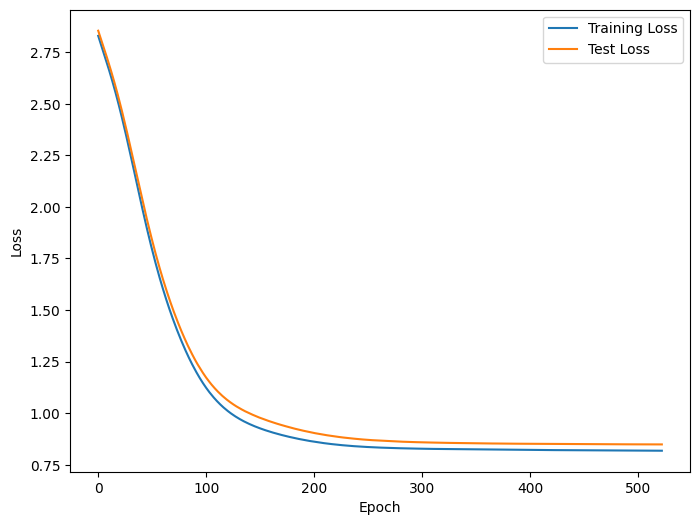

In [98]:
# Definir la función de pérdida y el optimizador
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimizer = optim.Adam(params=model.parameters(), lr=lr,  betas=(0.9, 0.999), eps=1e-07, weight_decay=0)

# Definir las listas para almacenar las pérdidas
train_losses = []
test_losses = []

# Inicializar contador de parada anticipada 
counter = 0
best_loss = np.inf  # Establecer la pérdida inicial a infinito

# Bucle de entrenamiento
for epoch in range(nEpoch):
    running_loss = 0.0
    for x_mnl, x_mlp, labels in train_loader_lmnl:
        
        # Poner a cero los gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_mnl,x_mlp)   

        # Calcular la perdida
        loss = loss_fn(outputs, labels)

        # Backward pass y optimizacion
        loss.backward()
        optimizer.step()

        running_loss += loss.item() # Log-verosimilitud en el conjunto de entrenamiento

    # Evaluar en el conjunto de prueba
    test_loss = evaluate_lmnl(model, loss_fn, test_loader_lmnl)

    if epoch == 0 or (epoch + 1) % status == 0:
        print(f'Epoch [{epoch+1:5.0f}/{nEpoch}], Train Loss: {running_loss:0.3f}, Test Loss: {test_loss:0.3f}')

    train_losses.append(running_loss)
    test_losses.append(test_loss)

    # Implementar la parada anticipada
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Parada anticipada en la época {epoch+1}')
            break
        
print(f'\nEntrenamiento terminado.\tPérdida de entrenamiento: {running_loss:0.3f}, Pérdida de test: {test_loss:0.3f}')
show_loss_plot(train_losses, test_losses, num_obs_train, num_obs_test)

In [99]:
# Calcular la disposición a pagar para reducir el tiempo caminado al supermercado en un minuto
LL_LMNL = best_loss
B_transport_LMNL = model.B_transport.weight.data.item()
B_stores_LMNL = model.B_stores.weight.data.item()

WTP_LMNL = B_stores_LMNL/B_transport_LMNL
print(f'\nLa disposición a pagar para reducir un minuto el tiempo de caminata hasta el supermercado es: {WTP_LMNL:.2f} minutos caminando hasta el transporte público')


La disposición a pagar para reducir un minuto el tiempo de caminata hasta el supermercado es: 0.91 minutos caminando hasta el transporte público


`Reflexiones`
1. El modelo L-MNL consigue un ajuste del modelo muy próximo al modelo MLP totalmente flexible
1. El modelo L-MNL permite comprender la relación entre la distancia a los supermercados y la distancia al transporte público.
1. Los resultados recuperan que la WTP no es estable, sino que fluctúa a lo largo de los entrenamientos.

## `Ejercicio 4: Características L-MLP`<br>

`A` Pruebe a reducir el número de características que se introducen en el MLP y evalúe el impacto en el rendimiento del modelo y la WTP. Es decir, utilice sólo «RESPCITY» y «WOMAN».

$\color{green}{\text{Añada aquí sus respuestas}}$

In [100]:
# Añade tu código aquí

In [101]:
do_exercise4 = False
if do_exercise4 == True:
    
    features_socio = ['WOMAN_1', 'RESPCITY_2', 'RESPCITY_3', 'RESPCITY_4']

    x_mlp_train = x_train_scaled[features_mlp_alt + features_socio]
    x_mlp_test  = x_test_scaled[features_mlp_alt + features_socio]
    
    x_mlp_train_tensor = torch.tensor(x_mlp_train.values, dtype=torch.float)
    x_mlp_test_tensor = torch.tensor(x_mlp_test.values, dtype=torch.float)
    

    dataset_train_lmnl = TensorDataset(x_mnl_train_tensor, x_mlp_train_tensor, y_train_dummy_tensor)
    train_loader_lmnl = DataLoader(dataset_train_lmnl, batch_size=250, shuffle=True)
    dataset_test_lmnl = TensorDataset(x_mnl_test_tensor, x_mlp_test_tensor, y_test_dummy_tensor)
    test_loader_lmnl = DataLoader(dataset_test_lmnl, batch_size=len(x_test_tensor), shuffle=False)


    input_size_mlp = x_mlp_train_tensor.size()[1] 

`A.ii` Volver a entrenar el modelo MLP utilizando la celda anterior:  <br>

Pérdida de entrenamiento: 6019,589, Pérdida de test: 1378,459 y la Disposición a pagar por reducir un minuto el tiempo de caminata hasta los supermercados es: 1,02 minutos de caminata hasta el transporte público.

## `Ejercicio 5: Predicción utilizando L-MNL`<br>

Un investigador desearía utilizar este modelo para hacer predicciones sobre la cuota de mercado. Sin embargo, esto es más difícil.<br>

`A` Explique 2 razones por las que realizar previsiones con el modelo L-MNL es menos sencillo que con los modelos MNL.<br>
`B` Explique 2 argumentos a favor de la utilización del modelo L-MNL como base para la elaboración de políticas.<br>
`C` Supongamos que le contratan para ayudar y asesorar a este investigador. ¿Qué le aconsejaría, por ejemplo, en cuanto a la especificación del modelo L-MNL, la formación, la evaluación comparativa, etc.?<br>

$\color{green}{\text{Añada aquí sus respuestas}}$

In [102]:
# Añade tu código aquí

`A` <br>
(1) El modelo hace predicciones diferentes cada vez que lo entrenamos. Para tener esto en cuenta, el investigador probablemente deba entrenar varios modelos y promediar las predicciones.<br>
(2) En caso de que se utilicen variables sociodemográficas, las predicciones del modelo L-MNL son condicionales a las variables sociodemográficas. En caso de que la muestra esté sesgada (por ejemplo, demasiadas mujeres/jóvenes, etc., no está claro cómo corregirlo).<br>
(3) Los tiempos de entrenamiento y el preprocesamiento de datos son más largos y laboriosos<br>
(4) El modelo es menos fácil de explicar a los no especialistas que un simple modelo MNL. Por ejemplo, los responsables políticos son reacios a basar sus decisiones en modelos que no comprenden.<br>

`B` <br>
(1) Empíricamente, el modelo L-MNL consigue un ajuste considerablemente mejor. Esto significa que el modelo es capaz de replicar mejor el comportamiento de elección y, como corolario, las predicciones son más precisas.<br>
(2) Conceptualmente, el modelo MNL lineal aditivo es demasiado simplista para captar las complejidades del comportamiento de elección humano real.<br>

`C` 
- Utilizar el modelo MNL para probar las interacciones/no linealidades esperadas
- Probar numerosas especificaciones para el L-MNL, en términos de características. 
- Evalúe la especificación en términos de ajuste, pero también en términos de WTP implícitas. 
- Realice un ajuste adecuado de los hiperparámetros.
- Comparar siempre los resultados con el RUM-MNL. 
- Tener en cuenta la estocasticidad del modelo L-MNL promediando numerosas ejecuciones. 
